In [57]:
import logging
logging.basicConfig(level=logging.INFO)

import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import click
from torch.utils.data import DataLoader,random_split,TensorDataset

from datamaestro import prepare_dataset
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import numpy as np
from keras.datasets import mnist
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from torch.utils.data import Subset
import datetime
import argparse

import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import optuna

In [58]:
BATCH_SIZE = 311
TRAIN_RATIO = 0.05
LOG_PATH = "/tmp/runs/lightning_logs"


In [59]:
class LitMnistData(pl.LightningDataModule):

    def __init__(self,batch_size=BATCH_SIZE,train_ratio=TRAIN_RATIO):
        super().__init__()
        self.dim_in = None
        self.dim_out = None
        self.batch_size = batch_size
        self.train_ratio = train_ratio

    def prepare_data(self):
        ### Do not use "self" here.
        prepare_dataset("com.lecun.mnist")

    def setup(self,stage=None):
        ds = prepare_dataset("com.lecun.mnist")
        if stage =="fit" or stage is None:
            # Si on est en phase d'apprentissage
            shape = ds.train.images.data().shape
            self.dim_in = shape[1]*shape[2]
            self.dim_out = len(set(ds.train.labels.data()))
            ds_train = TensorDataset(torch.tensor(ds.train.images.data()).view(-1,self.dim_in).float()/255., torch.tensor(ds.train.labels.data()).long())
            train_length = int(shape[0]*self.train_ratio)
            self.mnist_train, self.mnist_val, = random_split(ds_train,[train_length,shape[0]-train_length])
        if stage == "test" or stage is None:
            # en phase de test
            self.mnist_test= TensorDataset(torch.tensor(ds.test.images.data()).view(-1,self.dim_in).float()/255., torch.tensor(ds.test.labels.data()).long())

    def train_dataloader(self):
        return DataLoader(self.mnist_train,batch_size=self.batch_size)
    def val_dataloader(self):
        return DataLoader(self.mnist_val,batch_size=self.batch_size)
    def test_dataloader(self):
        return DataLoader(self.mnist_test,batch_size=self.batch_size)





In [60]:
class MLP3(nn.Module):
    def __init__(self, dim_in, l, dim_out):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(dim_in, l), nn.ReLU(), nn.Linear(l, l), nn.ReLU(), nn.Linear(l, dim_out))

    def forward(self, x):
        x = self.model(x)
        return x



In [61]:

def train(train_loader, test_loader, model, optimizer, epoch, device, writer, param_reg_l1=None):
    l_train = []
    l_val = []
    a_train = []
    a_val = []
    
    criterion = nn.CrossEntropyLoss()  

    write_tensorboard = epoch//20

    for e in tqdm(range(epoch)):
        loss_train = []
        loss_val = []
        acc_train = []
        acc_val = []

        ##################
        ###### Train #####
        ##################

        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
           
            # Régularisation L1 
            if param_reg_l1 != None : 
                l1_reg = torch.tensor(0.0, requires_grad=True).to(device)
                for param in model.parameters():
                    l1_reg = l1_reg + torch.norm(param, 1)
                loss = loss + param_reg_l1 * l1_reg

            loss.backward()
            optimizer.step()
            
            loss_train.append(loss.item())
            acc_train.append((output.argmax(1).detach().to('cpu') == target.detach().to('cpu')).sum().item() / len(target))
        
        l_train.append(np.mean(loss_train))
        a_train.append(np.mean(acc_train))

        if write_tensorboard != 0 and e % write_tensorboard == 0:
 


            writer.add_scalar('Loss train', np.mean(loss_train), e)
        
        
            for name, weight in model.named_parameters():
                writer.add_histogram(name, weight, e)
                writer.add_histogram(f'{name}.grad', weight.grad, e)

            entropie = criterion(output,target)
            writer.add_histogram('Entropy train', entropie, e)

         
            writer.add_scalar('Accuracy train', np.mean(acc_train), e)

        ##################
        ###### Eval ######
        ##################

        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                loss_val.append(loss.item())
                acc_val.append((output.argmax(1).detach().to('cpu') == target.detach().to('cpu')).sum().item() / len(target))

        l_val.append(np.mean(loss_val))
        a_val.append(np.mean(acc_val))

        if write_tensorboard != 0 and e % write_tensorboard == 0:
 

            writer.add_scalar('Loss validation', np.mean(loss_val), e)
        
        
            for name, weight in model.named_parameters():
                writer.add_histogram(name, weight, e)
                writer.add_histogram(f'{name}.grad', weight.grad, e)

            entropie = criterion(output,target)
            writer.add_histogram('Entropy validation', entropie, e)

         
            writer.add_scalar('Accuracy validation', np.mean(acc_val), e)
    
    return l_train, l_val, a_train, a_val


In [62]:
def test(test_loader, model, device):
    acc = 0
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            acc += (output.argmax(1).detach().to('cpu') == target.detach().to('cpu')).sum().item() / len(target)
 
    acc /= len(test_loader)
    return acc

In [63]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cpu


In [64]:
data = LitMnistData()
data.prepare_data()

data.setup()
train_loader = data.train_dataloader()
val_loader  = data.val_dataloader()
test_loader = data.test_dataloader()

In [65]:
sub_train_length = int(len(train_loader.dataset) * TRAIN_RATIO)
sub_train_set = Subset(train_loader.dataset, range(sub_train_length))
sub_train_loader = DataLoader(sub_train_set, batch_size=train_loader.batch_size, shuffle=True)

In [66]:
dim_in = 784
dim_out = 10
train_length = 50000

In [67]:
epoch = 1000
dim_latent = 100
model = MLP3(dim_in, dim_latent, dim_out).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


In [68]:
writer = SummaryWriter("tp7/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [69]:
loss_train, loss_val, acc_train, acc_val = train(sub_train_loader, val_loader, model, optimizer, epoch, device, writer)

100%|██████████| 1000/1000 [09:03<00:00,  1.84it/s]


In [70]:
print(len(sub_train_loader.dataset))

150


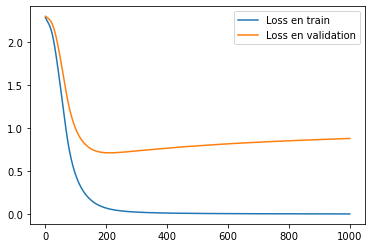

In [71]:
plt.figure()
plt.plot(loss_train,label="Loss en train")
plt.plot(loss_val,label="Loss en validation")
plt.legend()
plt.show()

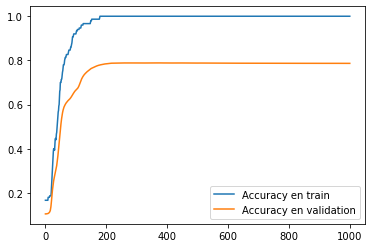

In [72]:
plt.figure()
plt.plot(acc_train,label="Accuracy en train")
plt.plot(acc_val,label="Accuracy en validation")
plt.legend()
plt.show()

In [73]:
print("accuracy en train : ", acc_train[-1])
print("accuracy en validation : ", acc_val[-1])

accuracy en train :  1.0
accuracy en validation :  0.7866320055406382


In [74]:
acc_test = test(test_loader, model, device)

In [75]:
print("accuracy en test : ", acc_test)


accuracy en test :  0.7955580726882976


## régularisation l1/l2

In [76]:
writer_reg = SummaryWriter("tp7_reg/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model_reg = MLP3(dim_in, dim_latent, dim_out).to(device)
l2_regularization = 0.01
param_regularization_l1 = 1e-5
optimizer_reg = torch.optim.SGD(model_reg.parameters(), lr=0.1, weight_decay=l2_regularization)
loss_train_reg, loss_val_reg, acc_train_reg, acc_val_reg =train(sub_train_loader, test_loader, model_reg, optimizer_reg, epoch, device, writer_reg, param_reg_l1=param_regularization_l1)


100%|██████████| 1000/1000 [01:32<00:00, 10.85it/s]


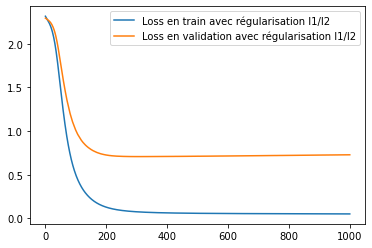

In [77]:
plt.figure()
plt.plot(loss_train_reg,label="Loss en train avec régularisation l1/l2")
plt.plot(loss_val_reg,label="Loss en validation avec régularisation l1/l2")
plt.legend()
plt.show()

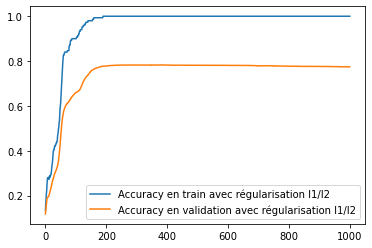

In [78]:
plt.figure()
plt.plot(acc_train_reg,label="Accuracy en train avec régularisation l1/l2")
plt.plot(acc_val_reg,label="Accuracy en validation avec régularisation l1/l2")
plt.legend()
plt.show()

In [79]:
print("accuracy en train : ", acc_train_reg[-1])
print("accuracy en validation : ", acc_val_reg[-1])

accuracy en train :  1.0
accuracy en validation :  0.7744689661892235


## Dropout 

In [80]:
class MLP3_Dropout(nn.Module):
    def __init__(self, dim_in, l, dim_out):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(dim_in, l), 
                                   nn.ReLU(), 
                                   nn.Dropout(0.1),
                                   nn.Linear(l, l), 
                                   nn.BatchNorm1d(l),
                                   nn.ReLU(), 
                                   nn.Dropout(0.1),
                                   nn.Linear(l, dim_out))

    def forward(self, x):
        x = self.model(x)
        return x

In [81]:
writer_reg_dropout = SummaryWriter("tp7_reg_dropout/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model_reg_dropout = MLP3_Dropout(dim_in, dim_latent, dim_out).to(device)
l2_regularization = 0.01
param_regularization_l1 = 1e-5
optimizer_reg = torch.optim.SGD(model_reg_dropout.parameters(), lr=0.1, weight_decay=l2_regularization)
loss_train_drop, loss_val_drop, acc_train_drop, acc_val_drop =train(sub_train_loader, test_loader, model_reg_dropout, optimizer_reg, epoch, device, writer_reg_dropout, param_reg_l1=param_regularization_l1)


100%|██████████| 1000/1000 [01:36<00:00, 10.40it/s]


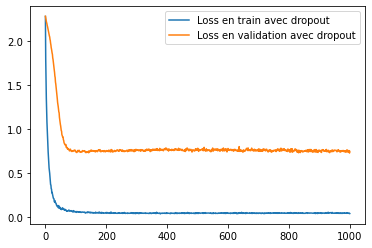

In [82]:
plt.figure()
plt.plot(loss_train_drop,label="Loss en train avec dropout")
plt.plot(loss_val_drop,label="Loss en validation avec dropout")
plt.legend()
plt.show()

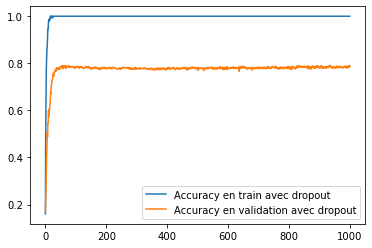

In [83]:
plt.figure()
plt.plot(acc_train_drop,label="Accuracy en train avec dropout")
plt.plot(acc_val_drop,label="Accuracy en validation avec dropout")
plt.legend()
plt.show()

In [84]:
print("accuracy en train : ", acc_train_drop[-1])
print("accuracy en validation : ", acc_val_drop[-1])

accuracy en train :  1.0
accuracy en validation :  0.786543083568807


## BatchNorm

In [85]:
class MLP3_dropout_batchNorm(nn.Module):
    def __init__(self, dim_in, l, dim_out):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(dim_in, l), 
                                   nn.BatchNorm1d(l),
                                   nn.ReLU(), 
                                   nn.Dropout(0.1),
                                   nn.Linear(l, l), 
                                   nn.BatchNorm1d(l),
                                   nn.ReLU(), 
                                   nn.Dropout(0.1),
                                   nn.Linear(l, dim_out))

    def forward(self, x):
        x = self.model(x)
        return x

In [86]:
writer_reg_dropout_batchnorm = SummaryWriter("tp7_reg_dropout_batchnorm/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model_reg_dropout_batchnorm = MLP3_dropout_batchNorm(dim_in, dim_latent, dim_out).to(device)
l2_regularization = 0.01
param_regularization_l1 = 1e-5
optimizer_reg = torch.optim.SGD(model_reg_dropout_batchnorm.parameters(), lr=0.1, weight_decay=l2_regularization)
loss_train_batch, loss_val_batch, acc_train_batch, acc_val_batch =train(sub_train_loader, test_loader, model_reg_dropout_batchnorm, optimizer_reg, epoch, device, writer_reg_dropout_batchnorm, param_reg_l1=param_regularization_l1)


100%|██████████| 1000/1000 [01:39<00:00, 10.03it/s]


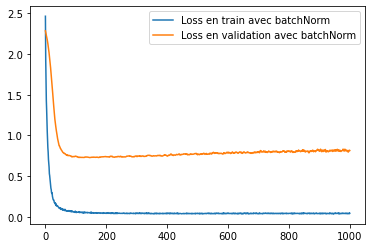

In [87]:
plt.figure()
plt.plot(loss_train_batch,label="Loss en train avec batchNorm")
plt.plot(loss_val_batch,label="Loss en validation avec batchNorm")
plt.legend()
plt.show()

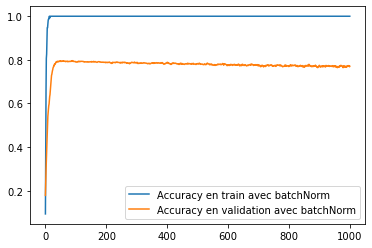

In [88]:
plt.figure()
plt.plot(acc_train_batch,label="Accuracy en train avec batchNorm")
plt.plot(acc_val_batch,label="Accuracy en validation avec batchNorm")
plt.legend()
plt.show()

In [89]:
print("accuracy en train : ", acc_train_batch[-1])
print("accuracy en validation : ", acc_val_batch[-1])

accuracy en train :  1.0
accuracy en validation :  0.7708008542011756


## Layer Norm

In [90]:
class MLP3_dropout_layerNorm(nn.Module):
    def __init__(self, dim_in, l, dim_out):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(dim_in, l), 
                                   nn.LayerNorm(l),
                                   nn.ReLU(), 
                                   nn.Dropout(0.1),
                                   nn.Linear(l, l), 
                                   nn.LayerNorm(l),
                                   nn.ReLU(), 
                                   nn.Dropout(0.1),
                                   nn.Linear(l, dim_out))

    def forward(self, x):
        x = self.model(x)
        return x

In [91]:
writer_reg_dropout_layernorm = SummaryWriter("tp7_reg_dropout_layernorm/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model_reg_dropout_layernorm = MLP3_dropout_layerNorm(dim_in, dim_latent, dim_out).to(device)
l2_regularization = 0.01
param_regularization_l1 = 1e-5
optimizer_reg = torch.optim.SGD(model_reg_dropout_layernorm.parameters(), lr=0.1, weight_decay=l2_regularization)
loss_train_layer, loss_val_layer, acc_train_layer, acc_val_layer =train(sub_train_loader, test_loader, model_reg_dropout_layernorm, optimizer_reg, epoch, device, writer_reg_dropout_layernorm, param_reg_l1=param_regularization_l1)


100%|██████████| 1000/1000 [01:32<00:00, 10.77it/s]


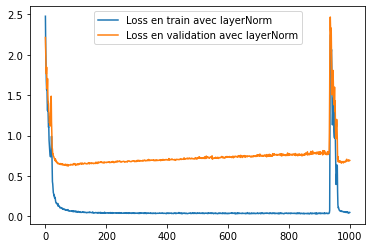

In [92]:
plt.figure()
plt.plot(loss_train_layer,label="Loss en train avec layerNorm")
plt.plot(loss_val_layer,label="Loss en validation avec layerNorm")
plt.legend()
plt.show()

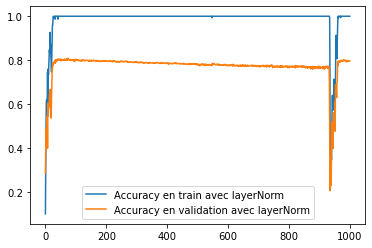

In [93]:
plt.figure()
plt.plot(acc_train_layer,label="Accuracy en train avec layerNorm")
plt.plot(acc_val_layer,label="Accuracy en validation avec layerNorm")
plt.legend()
plt.show()

In [94]:
print("accuracy en train : ", acc_train_layer[-1])
print("accuracy en validation : ", acc_val_layer[-1])

accuracy en train :  1.0
accuracy en validation :  0.795998570918185


## Recherche d’hyperparamètre

In [95]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline

In [96]:
def objective(trial):

    dim_in =  784
    dim_out = 10

    param = {
        "l": trial.suggest_int('l', 10, 100)  ,
        "lr": trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    }
    model = MLP3_dropout_batchNorm(dim_in, param["l"], dim_out).to(device)
    optimizer = optim.SGD(model.parameters(), lr=param["lr"])
    epochs = 10 
    _, _, _, acc_val = train(sub_train_loader, test_loader, model, optimizer, epochs, device, None, param_reg_l1=None)

    return acc_val[-1]


In [97]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=100)

[I 2023-11-28 19:00:10,682] A new study created in memory with name: no-name-a64e895e-8830-48ce-87e5-ddeaf3f7d835
100%|██████████| 10/10 [00:00<00:00, 13.16it/s]
[I 2023-11-28 19:00:11,448] Trial 0 finished with value: 0.10356377277599142 and parameters: {'l': 40, 'lr': 5.3477006088327755e-05}. Best is trial 0 with value: 0.10356377277599142.
100%|██████████| 10/10 [00:01<00:00,  8.96it/s]
[I 2023-11-28 19:00:12,567] Trial 1 finished with value: 0.10258939881126376 and parameters: {'l': 52, 'lr': 0.00024350223222632195}. Best is trial 0 with value: 0.10356377277599142.
100%|██████████| 10/10 [00:01<00:00,  9.27it/s]
[I 2023-11-28 19:00:13,650] Trial 2 finished with value: 0.07535767644288544 and parameters: {'l': 41, 'lr': 0.0003333746180944005}. Best is trial 0 with value: 0.10356377277599142.
100%|██████████| 10/10 [00:01<00:00,  8.89it/s]
[I 2023-11-28 19:00:14,779] Trial 3 finished with value: 0.11993325538341615 and parameters: {'l': 30, 'lr': 0.00018522825646486625}. Best is tria

In [98]:
best_trial = study.best_trial
best_params = best_trial.params
print("Best trial:")
print(f"Accuracy: {best_trial.value}") 
print(f"Params: {best_params}")

Best trial:
Accuracy: 0.5678631166975219
Params: {'l': 76, 'lr': 0.09730736705117617}


In [99]:
plot_optimization_history(study)

In [100]:
plot_intermediate_values(study)

[W 2023-11-28 19:01:46,797] You need to set up the pruning feature to utilize `plot_intermediate_values()`


In [101]:
plot_parallel_coordinate(study)

In [102]:
plot_contour(study)

In [103]:
plot_slice(study)

In [104]:
plot_param_importances(study)

In [105]:
plot_edf(study)


In [106]:
plot_rank(study)


/tmp/ipykernel_21382/1593024665.py:1: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.



In [107]:
plot_timeline(study)

/tmp/ipykernel_21382/547629393.py:1: ExperimentalWarning:

plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.

